# Summary
#  [Importing libraries](#Importing-libraries)
#  [Initial configuration](#Initial-configuration)
#  [Importing Excel spreadsheet](#Defining-functions)
#  [Importing Excel spreadsheet](#Importing-Excel-spreadsheet)
# [Setting up a local copy of the NCBI taxonomy database](#Setting-up-a-local-copy-of-the-NCBI-taxonomy-database)
# [Geting NCBI TAX IDs](#Geting-NCBI-TAX-IDs)
# [Creating dataframe with all microorganisms in the rows and the plastics in the columns](#Creating-dataframe-with-all-microorganisms-in-the-rows-and-the-plastics-in-the-columns)
# [Filling the dataframe with plastic degrading data](#Filling-the-dataframe-with-plastic-degrading-data)
# [Getting tree topology from NCBI and creating the tree](#Getting-tree-topology-from-NCBI-and-creating-the-tree)
# [Creating Itol dataset files](#Creating-Itol-dataset-files)
# [Downloading all available genomes for the plastic degraders](#Downloading-all-available-genomes-for-the-plastic-degraders)
# [Creating itol dataset for microorganisms with available genomes](#Creating-itol-dataset-for-microorganisms-with-available-genomes)
# [Blasting genes against genomes](#Blasting-genes-against-genomes)
# [Creating itol datasets for genes](#Creating-itol-datasets-for-genes)

<a id='Importing-libraries'></a>
# Importing libraries

In [140]:
import pandas as pd
import numpy as np
import random, os, time
from ete3 import NCBITaxa
from ete3 import Tree
import seaborn as sns
import unicodedata
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

<a id='Initial-configuration'></a>
# Initial configuration

In [2]:
#If running on a Slurm cluster, change account name and change run_on_slurm variable to True.
account = "uoa00354"
run_on_slurm = True

<a id='Defining-functions'></a>
# Defining functions

In [319]:
def create_directory(directory_name):
    if os.path.exists(directory_name) == False:
        os.mkdir(directory_name)
    
def run_command(run_on_slurm, account, job_name, job_time, job_memory, job_cpus, job_command):
    if run_on_slurm == False:
        os.system(job_command)
    if run_on_slurm == True:
        f = open("run.sh", "w")
        f.write("""#!/bin/bash

#SBATCH --account="""+str(account)+"""
#SBATCH --job-name="""+str(job_name)+"""
#SBATCH --time="""+str(job_time)+"""
#SBATCH --mem="""+str(job_memory)+"""
#SBATCH --cpus-per-task="""+str(job_cpus)+"""

module load Python
module load BLAST

"""+job_command)
        f.close()
    
        os.system("sbatch run.sh")  
        os.system("rm run.sh")
    else:
        print("Please, set 'run_on_slurm' variable to True or False")
        
def is_error(func, *args, **kw):
    try:
        func(*args, **kw)
        return False
    except Exception:
        return True
    
def get_rank_count_percentage(rank,tax_id_list):
    rank_dict = {}
    for tax_id in tax_id_list:
        lineage = ncbi.get_lineage(tax_id)
        for tax_id_lineage in lineage:
            if rank in str(ncbi.get_rank([tax_id_lineage])):
                if tax_id_lineage not in rank_dict:
                    rank_dict[tax_id_lineage] = 1
                else:
                    rank_dict[tax_id_lineage] += 1
    sum = 0
    for key, value in rank_dict.items():
        sum += value
    for key, value in rank_dict.items():
        rank_dict[key] = (value/sum)*100
    return(rank_dict)

<a id='Importing-Excel-spreadsheet'></a>
# Importing Excel spreadsheet

In [4]:
df = pd.read_excel("Degraders_list.xlsx")
#Visualize part of the dataset.
df.head(7)

,Microorganism,Tax ID,Plastic,Ref,Enzyme,Gene,Sequence,Year
0,Absidia sp.,0,PHB,"Jeszeová, L., Puškárová, A., Bučková, M., Krak...",No,No,NaN,2018
1,Absidia sp.,0,PLA,"Jeszeová, L., Puškárová, A., Bučková, M., Krak...",No,No,NaN,2018
2,Achromobacter xylosoxidans,0,HDPE,"Kowalczyk, A., Chyc, M., Ryszka, P., & Latowsk...",No,No,NaN,2016
3,Acidovorax avenae,0,PCL,"Mergaert, J., Ruffieux, K., Bourban, C., Storm...",No,No,NaN,2000
4,Acidovorax avenae,0,PBSA,"Mergaert, J., Ruffieux, K., Bourban, C., Storm...",No,No,NaN,2000
5,Acidovorax delafieldii,0,PHBH,"Morohoshi, T., Oi, T., Aiso, H., Suzuki, T., O...",No,No,NaN,2018
6,Acidovorax delafieldii,0,PBSA,"Uchida, H., Nakajima-Kambe, T., Shigeno-Akutsu...",Lipase,No,NaN,2000


<a id='Setting-up-a-local-copy-of-the-NCBI-taxonomy-database'></a>
# Setting up a local copy of the NCBI taxonomy database

In [5]:
ncbi = NCBITaxa()

<a id='Geting-NCBI-TAX-IDs'></a>
# Geting NCBI TAX IDs

In [6]:
#If it returns an error, just wait, it will get the dataframe anyway.
for index, row in df.iterrows():
    if row["Tax ID"] == 0:
        name2taxid = ncbi.get_name_translator([row["Microorganism"]])
        df["Tax ID"][row.name] = str(name2taxid.values()).replace("[","").replace("]","").split("(")[1].split(")")[0]
df.head(7)

/home/vmar559/PyPackages/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Microorganism,Tax ID,Plastic,Ref,Enzyme,Gene,Sequence,Year
0,Absidia sp.,1982014,PHB,"Jeszeová, L., Puškárová, A., Bučková, M., Krak...",No,No,NaN,2018
1,Absidia sp.,1982014,PLA,"Jeszeová, L., Puškárová, A., Bučková, M., Krak...",No,No,NaN,2018
2,Achromobacter xylosoxidans,85698,HDPE,"Kowalczyk, A., Chyc, M., Ryszka, P., & Latowsk...",No,No,NaN,2016
3,Acidovorax avenae,80867,PCL,"Mergaert, J., Ruffieux, K., Bourban, C., Storm...",No,No,NaN,2000
4,Acidovorax avenae,80867,PBSA,"Mergaert, J., Ruffieux, K., Bourban, C., Storm...",No,No,NaN,2000
5,Acidovorax delafieldii,47920,PHBH,"Morohoshi, T., Oi, T., Aiso, H., Suzuki, T., O...",No,No,NaN,2018
6,Acidovorax delafieldii,47920,PBSA,"Uchida, H., Nakajima-Kambe, T., Shigeno-Akutsu...",Lipase,No,NaN,2000


<a id='Creating-dataframe-with-all-microorganisms-in-the-rows-and-the-plastics-in-the-columns'></a>
# Creating dataframe with all microorganisms in the rows and the plastics in the columns

In [7]:
plastic_types = df['Plastic'].unique()
tax_ids = df['Tax ID'].unique()
df2 = pd.DataFrame(0, index=tax_ids, columns=plastic_types)
df2.sort_index(inplace=True)
df2.sort_index(axis=1, inplace=True)
df2.head(7)

,BTA copolyester,Ecoflex,HDPE,LDPE,LDPE Blend,Mater-Bi,Nylon,Nylon 12,Nylon 4,Nylon 6,...,PTC,PTMS,PTS,PU,PU Blend,PVA-LLDPE,PVC,PVC Blend,Polyether sulfone,Sky-Green
232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id='Filling-the-dataframe-with-plastic-degrading-data'></a>
# Filling the dataframe with plastic degrading data

In [8]:
references_dict = {}
for index, row in df.iterrows():
    plastic = row['Plastic']
    tax_id = row['Tax ID']
    reference = str(row['Ref'].strip())
    normalized = unicodedata.normalize('NFD', reference)
    reference = u"".join([c for c in normalized if not unicodedata.combining(c)])+"<br><br>"
    df2.at[tax_id, plastic] = 1
    if tax_id not in references_dict.keys():
        references_dict[tax_id] = reference
    else:
        if reference not in references_dict[tax_id]:
            references_dict[tax_id] += reference
df2.head(7)

,BTA copolyester,Ecoflex,HDPE,LDPE,LDPE Blend,Mater-Bi,Nylon,Nylon 12,Nylon 4,Nylon 6,...,PTC,PTMS,PTS,PU,PU Blend,PVA-LLDPE,PVC,PVC Blend,Polyether sulfone,Sky-Green
232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
287,0,0,1,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
294,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id='Getting-tree-topology-from-NCBI-and-creating-the-tree'></a>
# Getting tree topology from NCBI and creating the tree

In [9]:
ids = df2.index.values
t = ncbi.get_topology(ids, intermediate_nodes=True)
t.write(format=8, outfile="tree.nw")
ids = df2.index.values
t = ncbi.get_topology(ids, intermediate_nodes=True)
t.write(format=8, outfile="tree.nw")
#http://phylogeny.lirmm.fr/phylo_cgi/data_converter.cgi

<a id='Creating-Itol-dataset-files'></a>
# Creating Itol dataset files

In [12]:
r = lambda: random.randint(0,255) #Creates random hexadecimal color codes
create_directory("itol_datasets")

for column in df2.columns:
    f = open("itol_datasets/"+column.rstrip()+".txt", "w")
    f.write("""DATASET_BINARY
SEPARATOR COMMA
DATASET_LABEL,"""+column+"""
COLOR,"""+'#%02X%02X%02X' % (r(),r(),r())+"""
FIELD_SHAPES,1
FIELD_LABELS,f1
DATA""")
    for index, row in df2.iterrows():
        tax_id = str(index)
        feature_binary = str(row[column])
        f.write("\n"+tax_id+","+feature_binary)
    f.close()

<a id='Downloading-all-available-genomes-for-the-plastic-degraders'></a>
# Downloading all available genomes for the plastic degraders

In [45]:
for tax_id in tax_ids:
    job_name = str(tax_id)+"_download"
    job_time = "05:00:00"
    job_memory = 100 #Amount of ram memory in MB
    job_cpus = 1
    job_command = "ncbi-genome-download -s genbank --format fasta --taxid "+str(tax_id)+" -r 5 -o genomes/"+str(tax_id)+"/ fungi,bacteria"
    run_command(run_on_slurm, account, job_name, job_time, job_memory, job_cpus, job_command)
    time.sleep(2)

<a id='Creating-itol-dataset-for-microorganisms-with-available-genomes'></a>
# Creating itol dataset for microorganisms with available genomes

In [13]:
create_directory("itol_datasets_genomes")
directories_list = os.listdir("genomes")

f = open("itol_datasets_genomes/Available_genomes.txt", "w")
f.write("""DATASET_BINARY
SEPARATOR COMMA
DATASET_LABEL,Available genomes
COLOR,#FF0000
FIELD_SHAPES,1
FIELD_LABELS,f1
DATA""")

for index, row in df2.iterrows():
    tax_id = str(index)
    if str(index) in directories_list:
        f.write("\n"+tax_id+","+"1")
    else:
        f.write("\n"+tax_id+","+"0")
f.close()

<a id='Blasting-genes-against-genomes'></a>
# Blasting genes against genomes

In [18]:
#Adding the TAX ID to all sequence names
create_directory("genomes_database")
os.system("touch genomes_database/genomes.fasta")
for directory in directories_list:
    os.system("zcat genomes/"+directory+"/genbank/*/*/*genomic.fna.gz | sed s/'^>'/'>"+directory+"_"+"'/g >> genomes_database/genomes.fasta")

#Creating BLAST database
os.system("makeblastdb -in genomes_database/genomes.fasta -dbtype nucl")

#Sending BLAST jobs
create_directory("blasts")
job_time = "01:00:00"
job_memory = 512 #Amount of ram memory in MB
job_cpus = 1
for index, row in df.iterrows():
    sequences = row["Sequence"]
    species_name = ncbi.get_taxid_translator([row["Tax ID"]])[row["Tax ID"]].replace("(","").replace(")","").replace(":","").replace(" ","_")
    if pd.notna(sequences) == True:
        for n in range(0, len(sequences.split(";"))):
            job_name = str(row["Tax ID"])+"_"+str(n)
            job_command = "echo '"+sequences.split(";")[n]+"' | tblastn -query - -db genomes_database/genomes.fasta -out blasts/"+species_name+"_"+row["Enzyme"].replace(" ","_")+"_"+str(n)+".tsv -outfmt 6"
            run_command(run_on_slurm, account, job_name, job_time, job_memory, job_cpus, job_command)
            time.sleep(2)


<a id='Creating-itol-datasets-for-all-genes'></a>
# Creating itol datasets for all genes

In [31]:
r = lambda: random.randint(0,255) #Creates random hexadecimal color codes

blast_outputs_list = os.listdir("blasts")
for file in blast_outputs_list:
    file_blast = open("blasts/"+file)
    blast = file_blast.readlines()
    file_itol = open("itol_datasets_genomes/"+file.replace("tsv", "txt"), "w")
    counting_dict = {}
    for line in blast:
        qseqid = line.rstrip().split("\t")[0]
        sseqid = line.rstrip().split("\t")[1].split("_")[0]
        pident = float(line.rstrip().split("\t")[2])
        length = int(line.rstrip().split("\t")[3])
        mismatch = int(line.rstrip().split("\t")[4])
        gapopen = int(line.rstrip().split("\t")[5])
        qstart = int(line.rstrip().split("\t")[6])
        qend = float(line.rstrip().split("\t")[7])
        sstart = float(line.rstrip().split("\t")[8])
        send = float(line.rstrip().split("\t")[9])
        evalue = float(line.rstrip().split("\t")[10])
        bitscore = float(line.rstrip().split("\t")[11])
        if evalue <= 1e-06 and pident >= 25:
            if sseqid not in counting_dict:
                counting_dict[sseqid] = 1
            else:
                counting_dict[sseqid] += 1
                
    file_itol.write("""DATASET_MULTIBAR
SEPARATOR TAB
DATASET_LABEL\t"""+file.replace('.tsv', '').replace('_', ' ')+"""
COLOR\t"""+'#%02X%02X%02X' % (r(),r(),r())+"""
FIELD_COLORS\t"""+'#%02X%02X%02X' % (r(),r(),r())+"""
FIELD_LABELS\t"""+file.replace('.tsv', '').replace('_', ' ')+"""
DATA""")    
    for index, row in df2.iterrows():
        if str(index) in counting_dict:
            file_itol.write("\n"+str(index)+"\t"+str(counting_dict[str(index)]))
        else:
            file_itol.write("\n"+str(index)+"\t0")
    file_blast.close()
    file_itol.close()

<a id='Creating-one-light-color-for-each-phylum'></a>
# Creating one light color for each phylum

In [20]:
phylum_color_dict = {}
phylum_color_list = []
for node in t.traverse("postorder"):
    if "'phylum'" in str(ncbi.get_rank([int(node.name)])):
        phylum_name = ncbi.get_taxid_translator([int(node.name)])[int(node.name)]
        phylum_color_list.append(phylum_name)
phylum_colors = sns.color_palette("hls", (len(phylum_color_list))).as_hex()
n = 0
for item in phylum_color_list:
    phylum_color_dict[item] = phylum_colors[n]
    n += 1

<a id='Creating-itol-datasets-for-phylum-labels'></a>
# Creating itol datasets for phylum labels

In [21]:
f = open("itol_datasets/Phylum_labels.txt", "w")
f.write("""DATASET_TEXT
SEPARATOR COMMA
DATASET_LABEL,Phylum Labels
COLOR,#ff0000
MARGIN,0
SHOW_INTERNAL,1
LABEL_ROTATION,0
STRAIGHT_LABELS,0
ALIGN_TO_TREE,0
SIZE_FACTOR,0
DATA
""")
for node in t.traverse("postorder"):
    if "'phylum'" in str(ncbi.get_rank([int(node.name)])):
        phylum_name = ncbi.get_taxid_translator([int(node.name)])[int(node.name)]
        f.write("\ninode"+node.name+","+phylum_name+",0,"+phylum_color_dict[phylum_name]+",bold,10,0")      
f.close()

<a id='Creating-itol-datasets-for-phylum-colored-ranges'></a>
# Creating itol datasets for phylum colored ranges

In [22]:
f = open("itol_datasets/Phylum_colors.txt", "w")
f.write("""TREE_COLORS
SEPARATOR COMMA
DATA
""")
for node in t.traverse("postorder"):
    if "'phylum'" in str(ncbi.get_rank([int(node.name)])):
        phylum_name = ncbi.get_taxid_translator([int(node.name)])[int(node.name)]
        f.write("\ninode"+node.name+",range,"+phylum_color_dict[phylum_name]+","+phylum_name)
f.close()

<a id='Creating-itol-datasets-for-references'></a>
# Creating itol datasets for references

In [23]:
f = open("itol_datasets/Popup_info.txt", "w")
f.write("""POPUP_INFO
SEPARATOR TAB
DATA
""")
for index, row in df2.iterrows():
    organism_name = ncbi.get_taxid_translator([index])[index]
    html_string = "<h1>"+organism_name+"</h1><br>NCBI ID = "+str(index)+"<br><br>References:<br><br>"+references_dict[index]
    f.write("\n"+str(index)+"\t"+organism_name+"\t"+html_string)
f.close()

<a id='Creating-file-with-TAX-IDs'></a>
# Creating file with TAX IDs

In [24]:
f = open("ids.txt", "w")
for item in ids:
    f.write(str(item)+"\n")
f.close()

<a id='Creating-tree-with-all-species'></a>
# Creating tree with all species

In [25]:
all_species_file = open("all_species_tax_ids.txt")
all_species = all_species_file.readlines()
all_bacteria_and_fungi = []
for item in all_species:
    tax_id = item.rstrip()
    if is_error(ncbi.get_lineage, tax_id) == False:
        lineage = ncbi.get_lineage(tax_id)
        fungi = 0
        eukaryota = 0
        for sub_item in lineage:
            if "Eukaryota" in ncbi.get_taxid_translator([str(sub_item)])[sub_item]:
                eukaryota = 1
            if "Fungi" in ncbi.get_taxid_translator([str(sub_item)])[sub_item]:
                fungi = 1
        if eukaryota == 0:
            all_bacteria_and_fungi.append(tax_id)
        else:
            if fungi == 1:
                all_bacteria_and_fungi.append(tax_id)

all_bacteria_and_fungi_subsample = random.sample(all_bacteria_and_fungi, 7000)                              

for item in ids:
    all_bacteria_and_fungi_subsample.append(str(item))
t_all_species = ncbi.get_topology(all_bacteria_and_fungi_subsample, intermediate_nodes=True)
t_all_species.write(format=8, outfile="tree_all_species.nw")

<a id='Creating-one-light-color-for-each-phylum-for-all-species-tree'></a>
# Creating one light color for each phylum for all species tree

In [26]:
phylum_color_dict_all_species = {}
phylum_color_list_all_species = []
for node in t_all_species.traverse("postorder"):
    if "'phylum'" in str(ncbi.get_rank([int(node.name)])):
        phylum_name = ncbi.get_taxid_translator([int(node.name)])[int(node.name)]
        phylum_color_list_all_species.append(phylum_name)
phylum_colors = sns.color_palette("hls", (len(phylum_color_list_all_species))).as_hex()
n = 0
for item in phylum_color_list_all_species:
    phylum_color_dict_all_species[item] = phylum_colors[n]
    n += 1

<a id='Creating-itol-datasets-for-phylum-colored-ranges-for-all-species-tree'></a>
# Creating itol datasets for phylum colored ranges for all species tree

In [27]:
f = open("itol_datasets/Phylum_colors_all_species.txt", "w")
f.write("""TREE_COLORS
SEPARATOR COMMA
DATA
""")
for node in t_all_species.traverse("postorder"):
    if "'phylum'" in str(ncbi.get_rank([int(node.name)])):
        phylum_name = ncbi.get_taxid_translator([int(node.name)])[int(node.name)]
        f.write("\ninode"+node.name+",range,"+phylum_color_dict_all_species[phylum_name]+","+phylum_name)
f.close()

<a id='Creating-itol-datasets-for-phylum-labels-for-all-species-tree'></a>
# Creating itol datasets for phylum labels for all species tree

In [28]:
f = open("itol_datasets/Phylum_labels_all_species.txt", "w")
f.write("""DATASET_TEXT
SEPARATOR COMMA
DATASET_LABEL,Phylum Labels
COLOR,#ff0000
MARGIN,0
SHOW_INTERNAL,1
LABEL_ROTATION,0
STRAIGHT_LABELS,0
ALIGN_TO_TREE,0
SIZE_FACTOR,0
DATA
""")
for node in t_all_species.traverse("postorder"):
    if "'phylum'" in str(ncbi.get_rank([int(node.name)])):
        phylum_name = ncbi.get_taxid_translator([int(node.name)])[int(node.name)]
        f.write("\ninode"+node.name+","+phylum_name+",0,"+phylum_color_dict_all_species[phylum_name]+",bold,10,0")      
f.close()

<a id='Creating-figure-with-number-of-publications-and-degraders-per-year'></a>
# Creating figure with number of publications and degraders per year

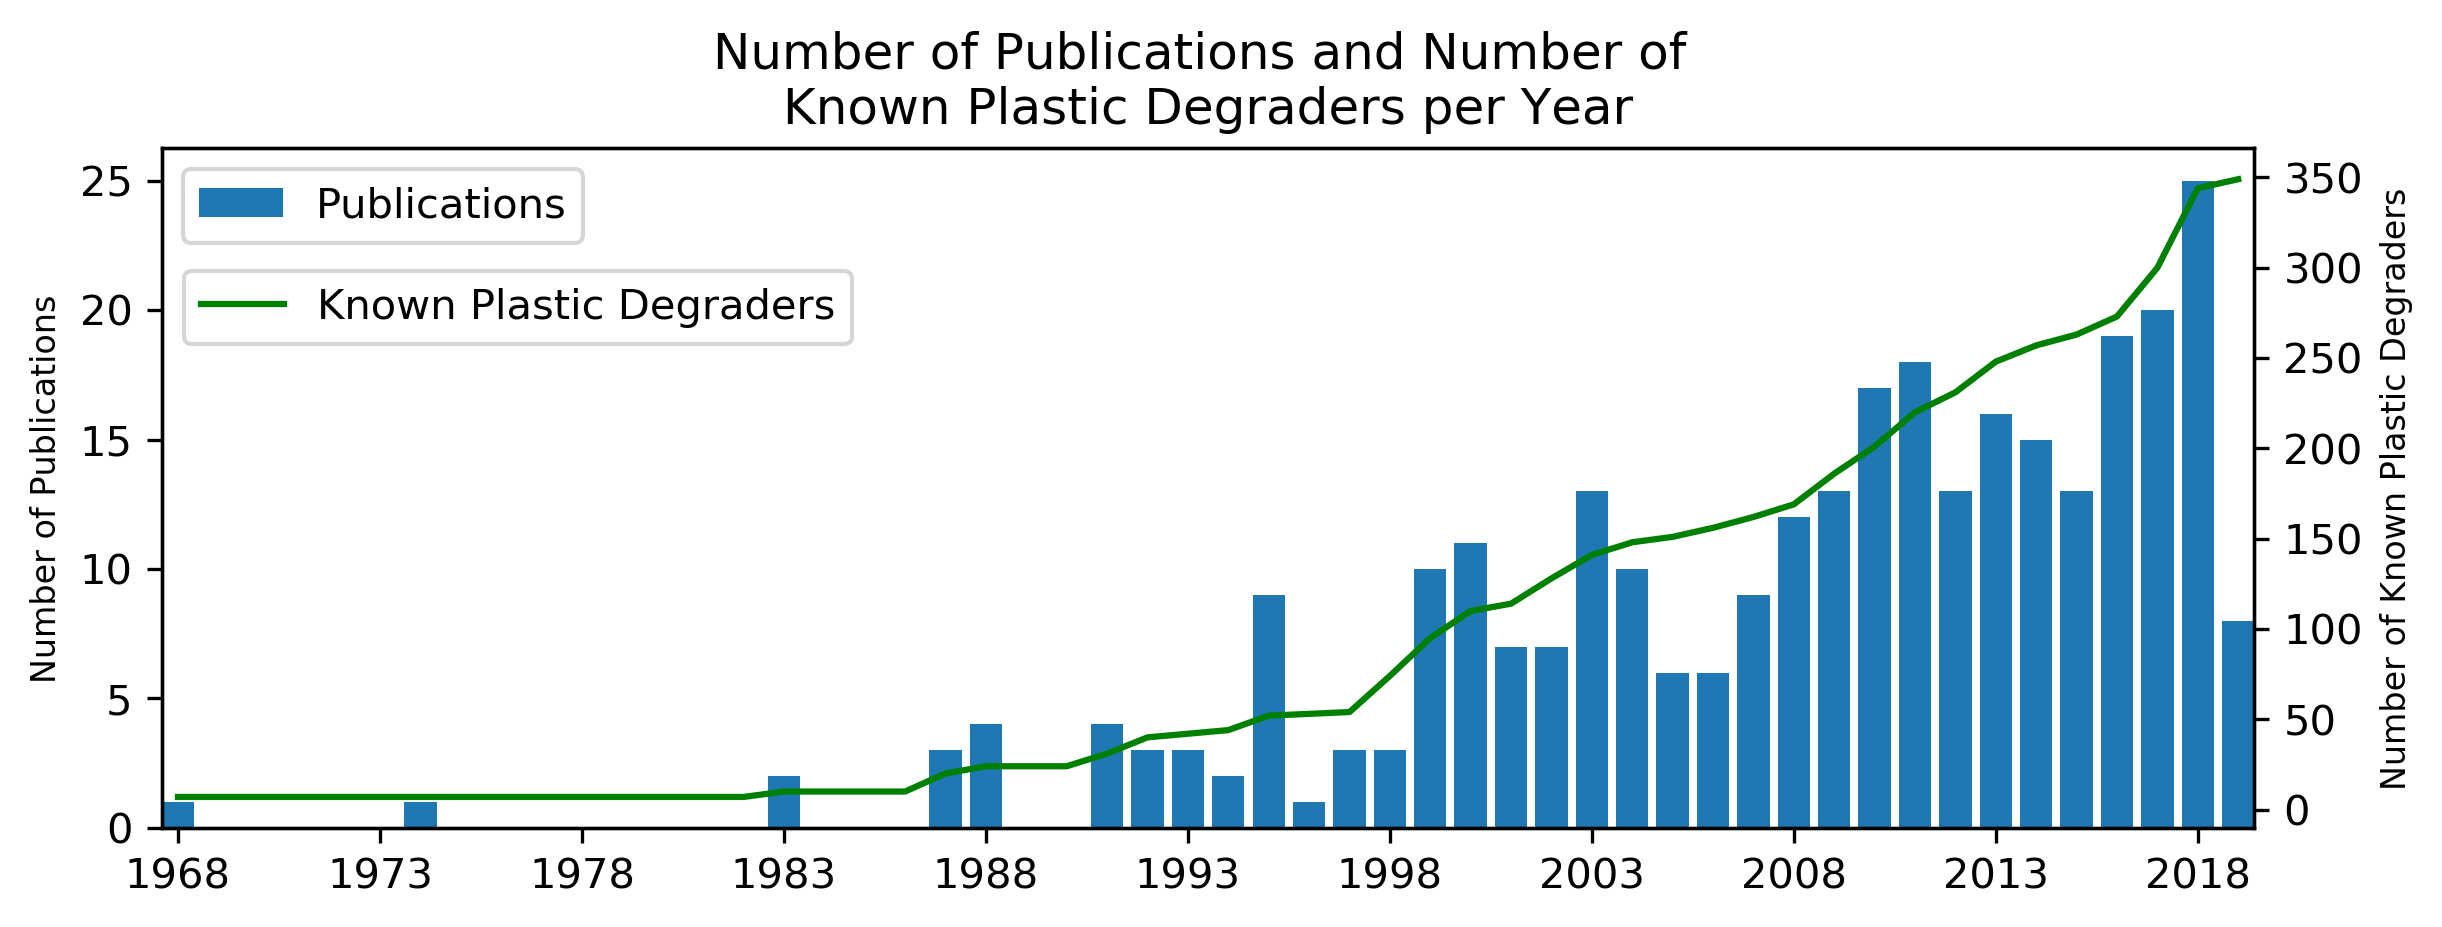

In [101]:
ref_dict, publication_count_dict = {}, {}
year_list = []

for index, row in df.iterrows():
    reference = row['Ref']
    year = row['Year']
    ref_dict[reference] = year

for key, value in ref_dict.items():
    year_list.append(value)
    if value not in publication_count_dict:
        publication_count_dict[value] = 1
    else:
        publication_count_dict[value] += 1

x, y = [], []

year_min = min(year_list)
year_max = max(year_list)

for n in range(year_min, year_max+1):
    if n in publication_count_dict:
        count = publication_count_dict[n]
        x.append(n)
        y.append(count)
    else:
        x.append(n)
        y.append(0)

figure(num=None, figsize=(9, 3), dpi=300, facecolor='w', edgecolor='k')
plt.clf()

ax1=plt.gca()
ax1.bar(x, y, label = "Publications")
ax1.set_ylabel("Number of Publications", fontsize=8)
ax1.legend(loc=0)

ids_year_dict = {}
year_count_dict = {}
x, y = [], []

for index, row in df.iterrows():
    ids = row['Tax ID']
    year = row['Year']
    if ids not in ids_year_dict:
        ids_year_dict[ids] = year
    else:
        if year < ids_year_dict[ids]:
            ids_year_dict[ids] = year

for key, value in ids_year_dict.items():
    if value not in year_count_dict:
        year_count_dict[value] = 1
    else:
        year_count_dict[value] += 1

year_sum = 0
for n in range(1968, 2020):
    if n in year_count_dict:
        year_sum += year_count_dict[n]
    x.append(n)
    y.append(year_sum)

ax2=ax1.twinx()
ax2.plot(x, y, color='green', label = "Known Plastic Degraders")
ax2.set_xticks(range(min(x), max(x)+1, 5))
ax2.set_ylabel("Number of Known Plastic Degraders", fontsize=8)
ax2.legend(loc=0, bbox_to_anchor=(0.34, 0.85,))

plt.margins(x=0)
plt.title('Number of Publications and Number of \nKnown Plastic Degraders per Year')
plt.show()  

<a id='Creating-figure-with-stacked-bars-to-show-relative-abundance'></a>
# Creating figure with stacked bars to show relative abundance

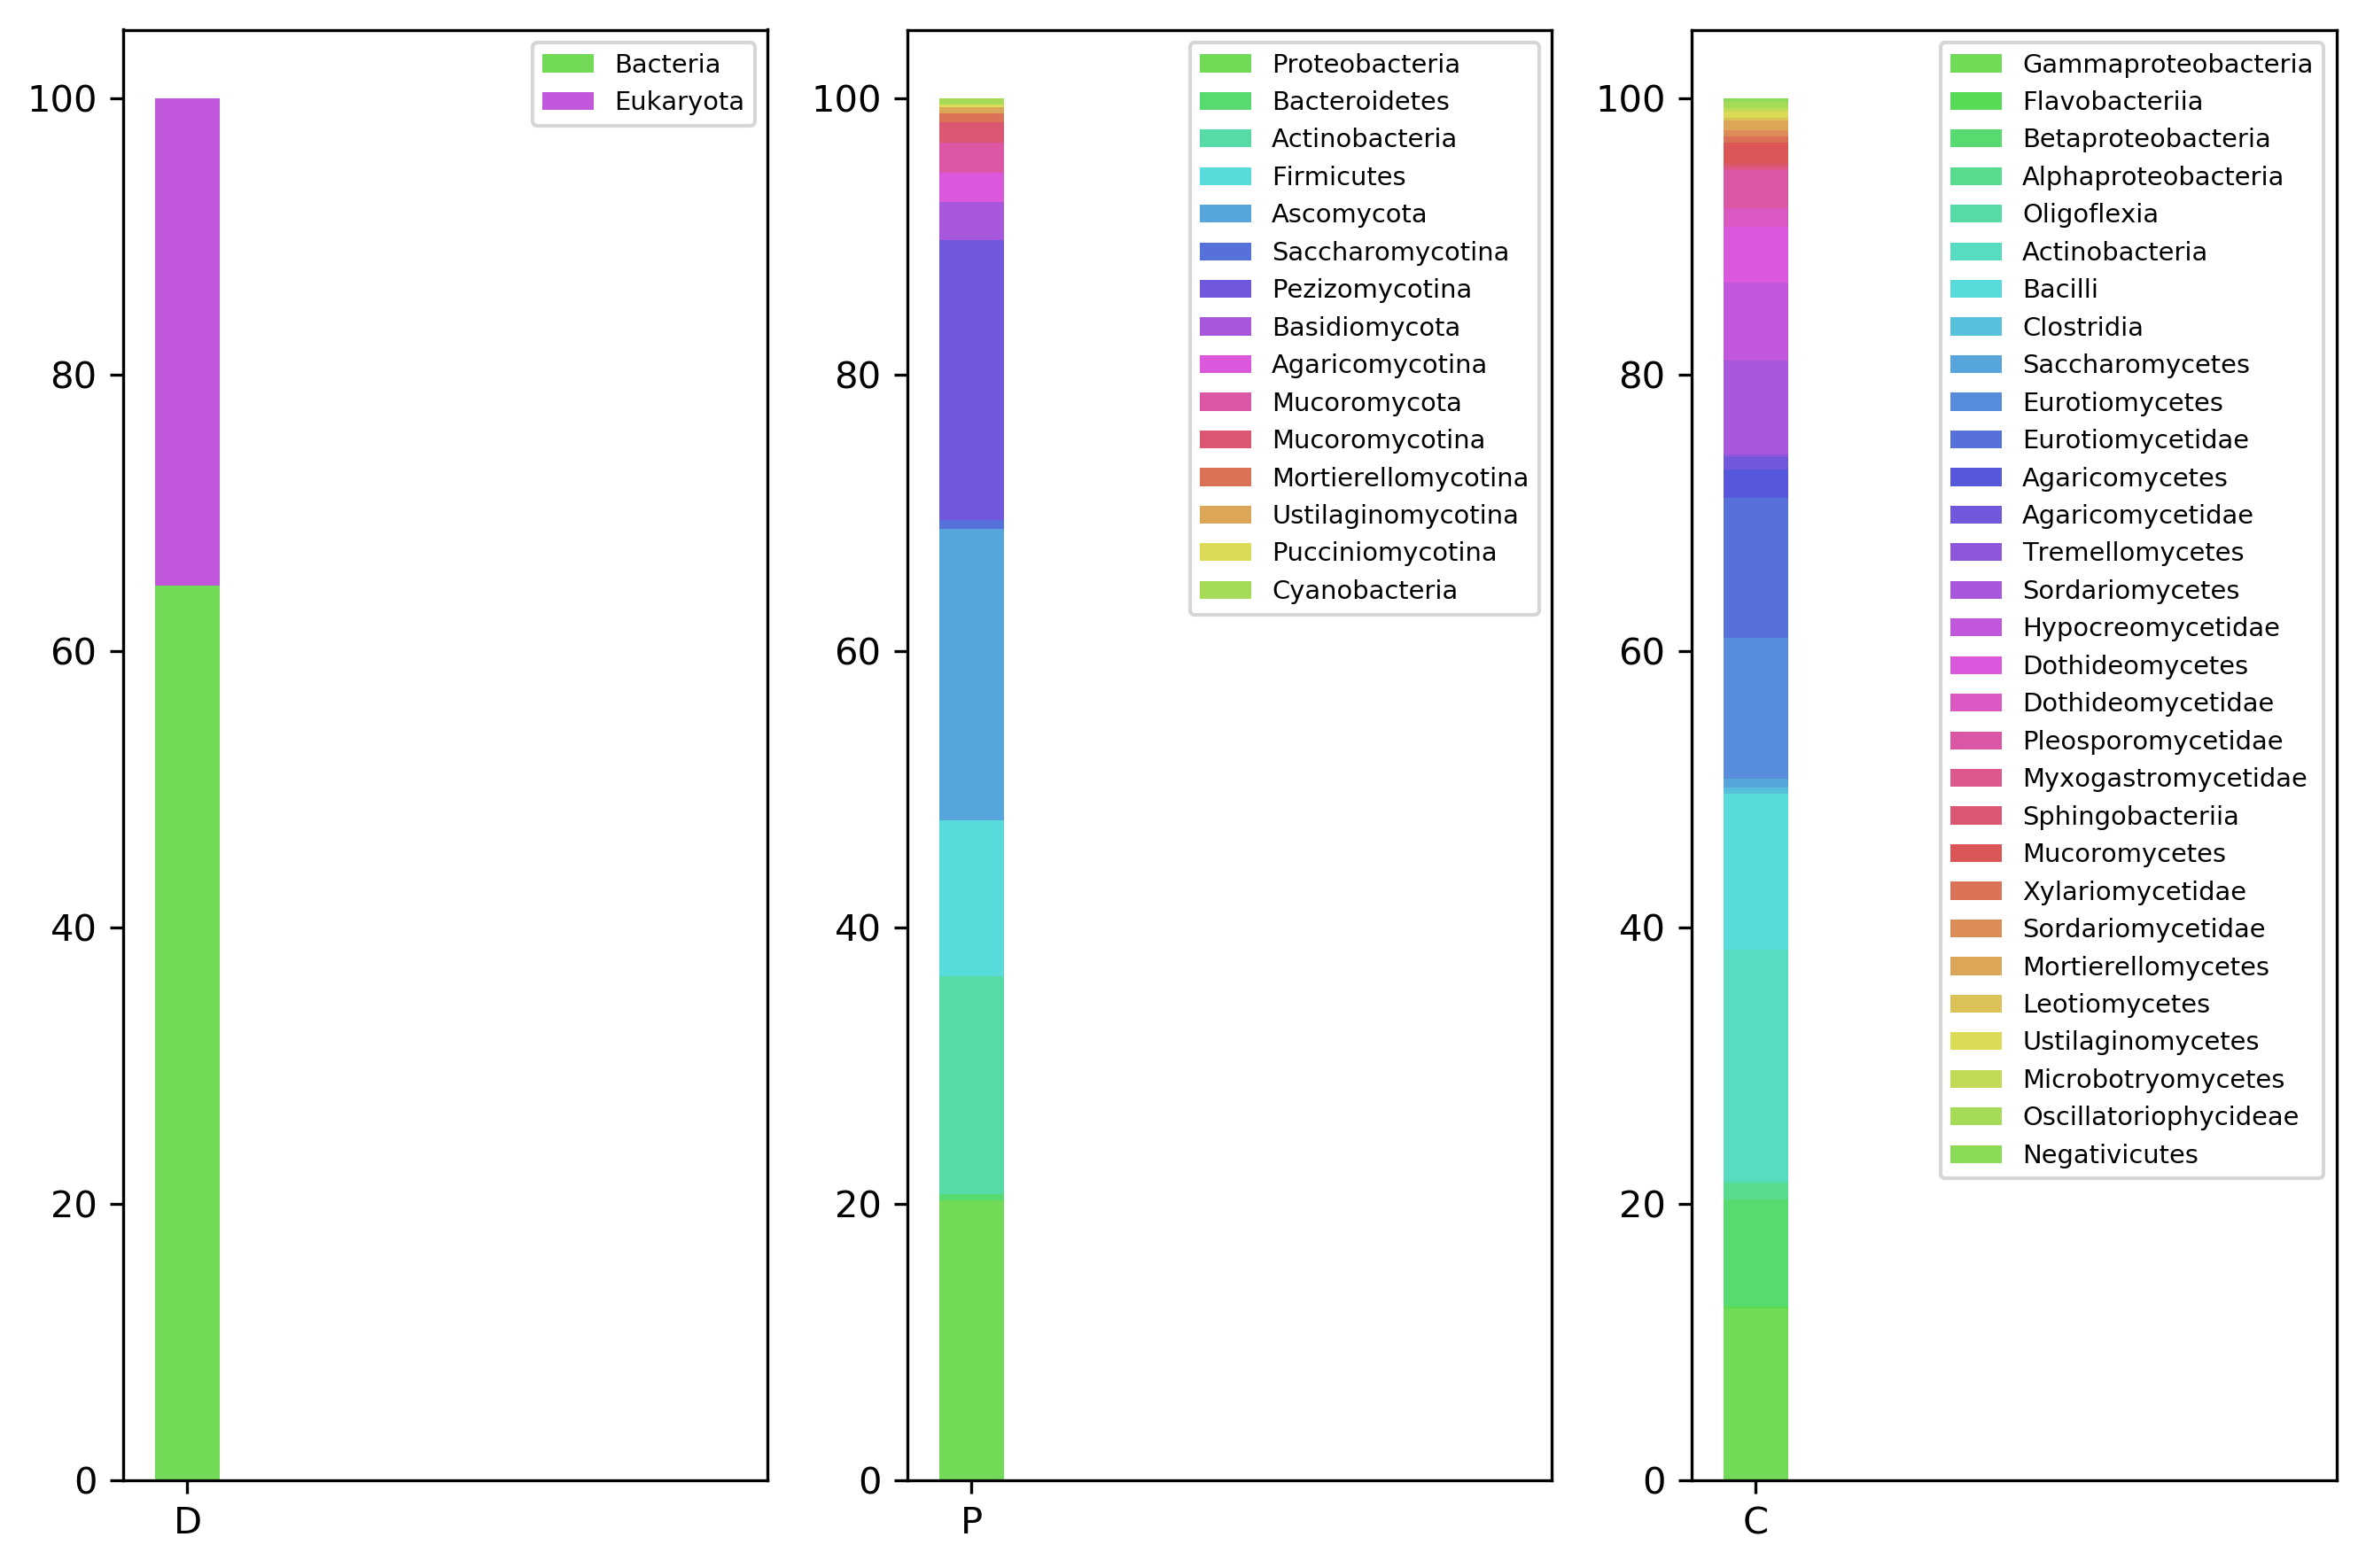

/opt/nesi/CS400_centos7_bdw/Python/3.7.3-gimkl-2018b/lib/python3.7/site-packages/matplotlib-3.0.3-py3.7-linux-x86_64.egg/matplotlib/tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


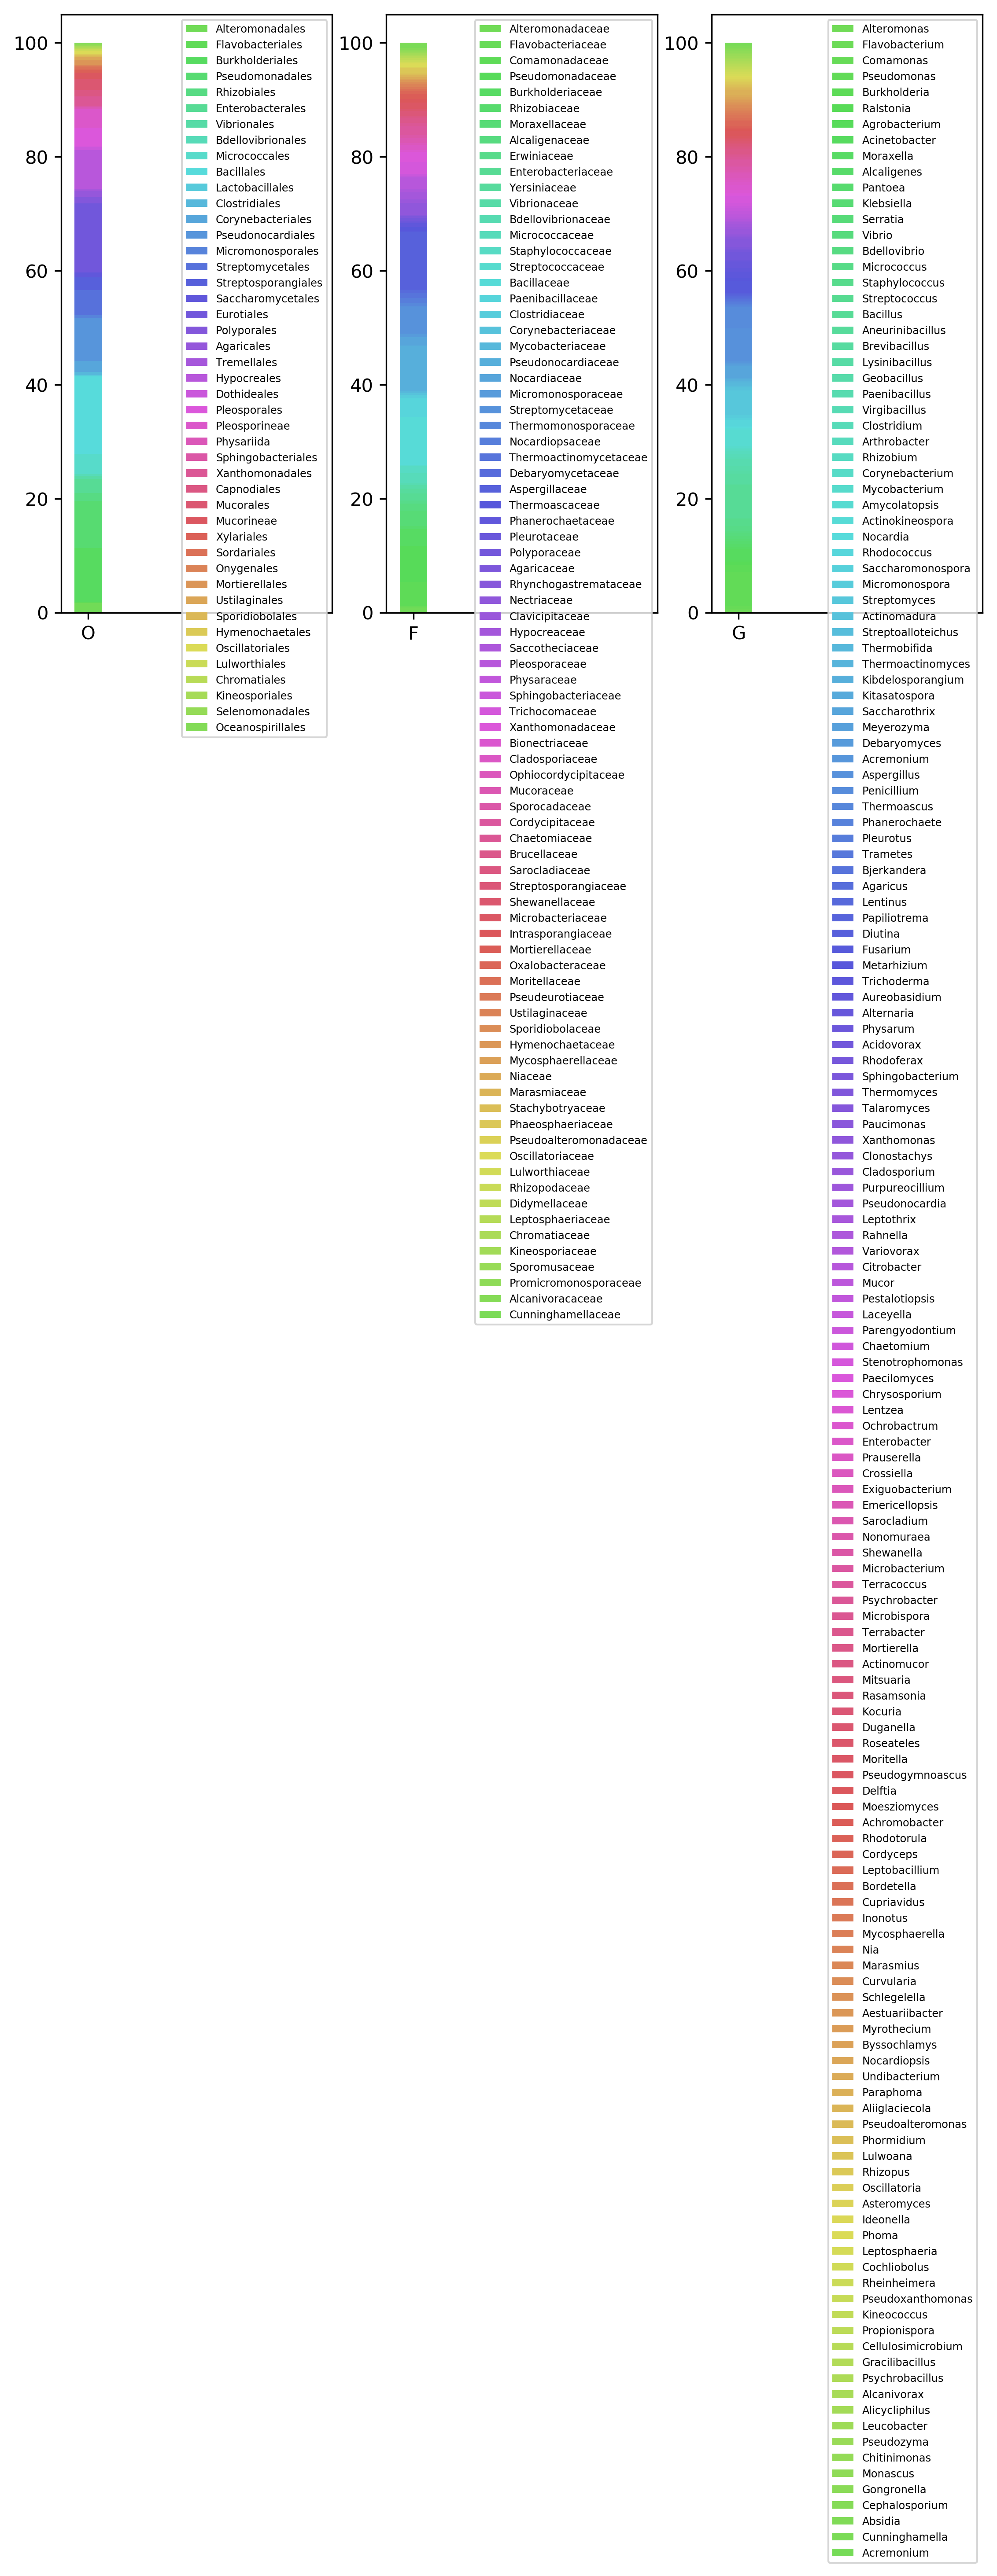

In [349]:
ids = df2.index.values

figure(num=None, figsize=(9, 6), dpi=300, facecolor='w', edgecolor='k')

plt.subplot(1, 3, 1)

x, y = [], []
for key, value in get_rank_count_percentage("superkingdom", ids).items():
    organism_name = ncbi.get_taxid_translator([key])[key]
    count = value
    x.append(organism_name)
    y.append(count)
    
chart_colors = sns.hls_palette(len(x), h = 0.3, l = 0.6).as_hex()

bottom_sum = 0
for n in range(0, len(x)):
    y_list = [y[n]]
    x_list = [x[n]]
    plt.bar(1, y_list, color = chart_colors[n], width=1, bottom=bottom_sum)
    bottom_sum += y[n]
plt.xticks([1], "Domain")
plt.xlim(0, 10)
plt.legend(x, fontsize = 'x-small')




plt.subplot(1, 3, 2)

x, y = [], []
for key, value in get_rank_count_percentage("phylum", ids).items():
    organism_name = ncbi.get_taxid_translator([key])[key]
    count = value
    x.append(organism_name)
    y.append(count)
    
chart_colors = sns.hls_palette(len(x), h = 0.3, l = 0.6).as_hex()

bottom_sum = 0
for n in range(0, len(x)):
    y_list = [y[n]]
    x_list = [x[n]]
    plt.bar(1, y_list, color = chart_colors[n], width=1, bottom=bottom_sum)
    bottom_sum += y[n]
plt.xticks([1], "Phylum")
plt.xlim(0, 10)
plt.legend(x, fontsize = 'x-small')

plt.subplot(1, 3, 3)

x, y = [], []
for key, value in get_rank_count_percentage("class", ids).items():
    organism_name = ncbi.get_taxid_translator([key])[key]
    count = value
    x.append(organism_name)
    y.append(count)
    
chart_colors = sns.hls_palette(len(x), h = 0.3, l = 0.6).as_hex()

bottom_sum = 0
for n in range(0, len(x)):
    y_list = [y[n]]
    x_list = np.array([x[n]])
    plt.bar(1, y_list, color = chart_colors[n], width=1, bottom=bottom_sum)
    bottom_sum += y[n]
plt.xticks([1], "Class")
plt.xlim(0, 10)
plt.legend(x, fontsize = 'x-small')


plt.tight_layout()
plt.show()












figure(num=None, figsize=(9, 6), dpi=300, facecolor='w', edgecolor='k')

plt.subplot(1, 3, 1)

x, y = [], []
for key, value in get_rank_count_percentage("order", ids).items():
    organism_name = ncbi.get_taxid_translator([key])[key]
    count = value
    x.append(organism_name)
    y.append(count)
    
chart_colors = sns.hls_palette(len(x), h = 0.3, l = 0.6).as_hex()

bottom_sum = 0
for n in range(0, len(x)):
    y_list = [y[n]]
    x_list = [x[n]]
    plt.bar(1, y_list, color = chart_colors[n], width=1, bottom=bottom_sum)
    bottom_sum += y[n]
plt.xticks([1], "Order")
plt.xlim(0, 10)
plt.legend(x, fontsize = 'xx-small')




plt.subplot(1, 3, 2)

x, y = [], []
for key, value in get_rank_count_percentage("family", ids).items():
    organism_name = ncbi.get_taxid_translator([key])[key]
    count = value
    x.append(organism_name)
    y.append(count)
    
chart_colors = sns.hls_palette(len(x), h = 0.3, l = 0.6).as_hex()

bottom_sum = 0
for n in range(0, len(x)):
    y_list = [y[n]]
    x_list = [x[n]]
    plt.bar(1, y_list, color = chart_colors[n], width=1, bottom=bottom_sum)
    bottom_sum += y[n]
plt.xticks([1], "Family")
plt.xlim(0, 10)
plt.legend(x, fontsize = 'xx-small')

plt.subplot(1, 3, 3)

x, y = [], []
for key, value in get_rank_count_percentage("genus", ids).items():
    organism_name = ncbi.get_taxid_translator([key])[key]
    count = value
    x.append(organism_name)
    y.append(count)
    
chart_colors = sns.hls_palette(len(x), h = 0.3, l = 0.6).as_hex()

bottom_sum = 0
for n in range(0, len(x)):
    y_list = [y[n]]
    x_list = np.array([x[n]])
    plt.bar(1, y_list, color = chart_colors[n], width=1, bottom=bottom_sum)
    bottom_sum += y[n]
plt.xticks([1], "Genus")
plt.xlim(0, 10)
plt.legend(x, fontsize = 'xx-small')


plt.tight_layout()
plt.show()